In [10]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Reading data from the dataset
subject = 'S2'
subject_path = '/mnt/bst/spouriye/pshedag1/PranitaProject/Research Paper Project/WESAD'
os.chdir(subject_path)
os.chdir(subject)
with open(subject + '.pkl', 'rb') as file:
    subject_data = pickle.load(file, encoding='latin1')
print(subject_data['subject'])
subject_data['signal']['wrist']

S2


{'ACC': array([[ 62., -21., 107.],
        [ 66.,  13.,  53.],
        [ 41.,   9.,  15.],
        ...,
        [ 41.,  25.,  11.],
        [ 39.,  27.,  22.],
        [ 56.,  26.,  10.]]),
 'BVP': array([[-59.37],
        [-53.42],
        [-44.4 ],
        ...,
        [ 18.26],
        [ 18.68],
        [ 19.71]]),
 'EDA': array([[1.138257],
        [1.125444],
        [1.011405],
        ...,
        [0.059208],
        [0.073303],
        [0.045113]]),
 'TEMP': array([[35.41],
        [35.41],
        [35.41],
        ...,
        [34.23],
        [34.23],
        [34.23]])}

In [11]:
# Getting wrist and lables data-
wrist_data = subject_data['signal']['wrist']
labels_data = subject_data['label']

In [12]:
# Getting Wrist Data
wrist_ACC_X = wrist_data['ACC'][:, 0]
wrist_ACC_Y = wrist_data['ACC'][:, 1]
wrist_ACC_Z = wrist_data['ACC'][:, 2]
wrist_BVP = wrist_data['BVP'][:,0]
wrist_EDA = wrist_data['EDA'][:,0]
wrist_TEMP = wrist_data['TEMP'][:,0]

In [13]:
# printint the length of all wrist data
for key, value in wrist_data.items():
    print(key, len(value))

ACC 194528
BVP 389056
EDA 24316
TEMP 24316


In [14]:
# printing the length of all lables data
labels_data_length = len(labels_data)
print('lables', labels_data_length)

lables 4255300


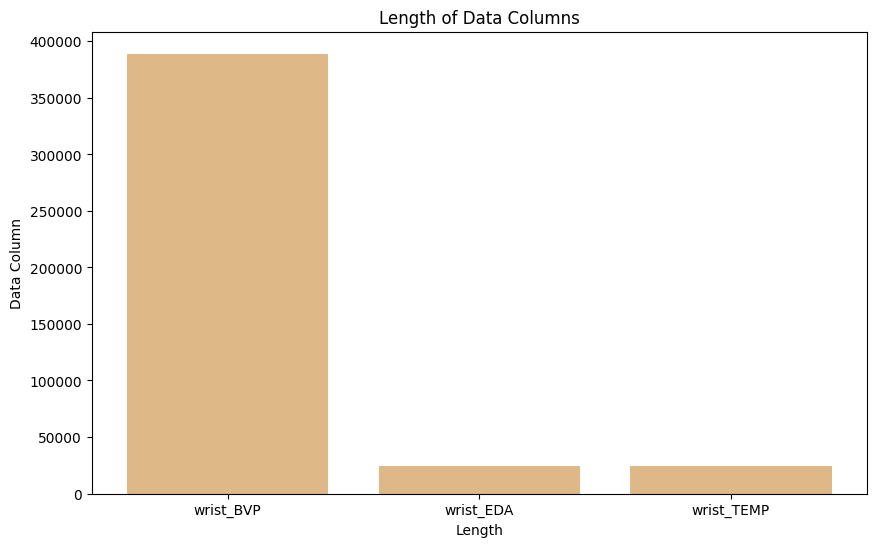

In [15]:
# Checking the data 
cols = ["wrist_BVP","wrist_EDA","wrist_TEMP"]
y_axis = [len(wrist_BVP),len(wrist_EDA),len(wrist_TEMP)]
plt.figure(figsize=(10, 6))
plt.bar(cols, y_axis, color='burlywood')
plt.xlabel('Length')
plt.ylabel('Data Column')
plt.title('Length of Data Columns')
plt.show()

In [16]:
downsample_factor_bvp = 64 // 4  # Downsampling factor from 64 Hz to 4 Hz
w_bvp = wrist_BVP[::downsample_factor_bvp]

In [17]:
downsample_factor_labels = 700 // 4  # Downsampling factor from 700 Hz to 4 Hz
labels = labels_data[::downsample_factor_labels]

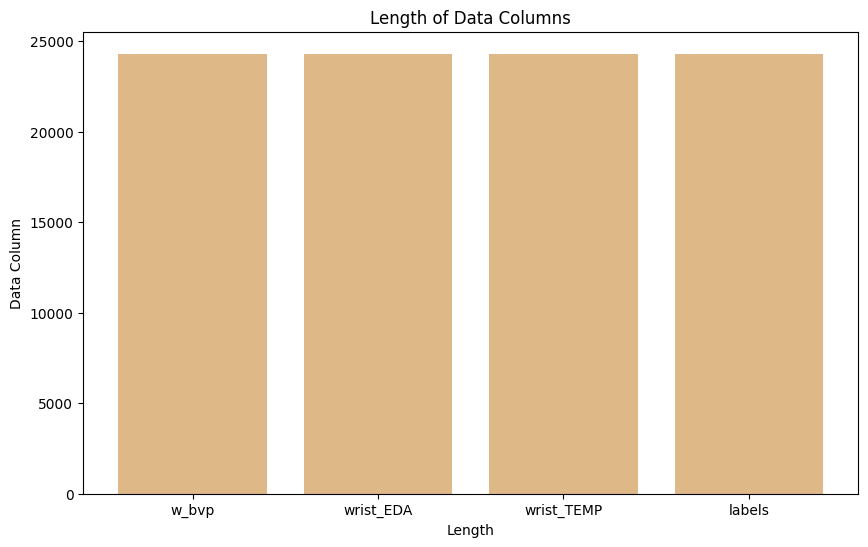

In [18]:
# Checking the data 
cols = ["w_bvp","wrist_EDA","wrist_TEMP", "labels"]
y_axis = [len(w_bvp),len(wrist_EDA),len(wrist_TEMP), len(labels)]
plt.figure(figsize=(10, 6))
plt.bar(cols, y_axis, color='burlywood')
plt.xlabel('Length')
plt.ylabel('Data Column')
plt.title('Length of Data Columns')
plt.show()

In [19]:
# Creating a pandas dataframe 
data = {
    "w_bvp": w_bvp,
    "wrist_EDA": wrist_EDA,
    "wrist_TEMP": wrist_TEMP,
    "labels": labels,
}
df = pd.DataFrame(data)
df

,w_bvp,wrist_EDA,wrist_TEMP,labels
0,-59.37,1.138257,35.41,0
1,43.50,1.125444,35.41,0
2,53.56,1.011405,35.41,0
3,54.64,1.033188,35.41,0
4,-117.88,0.935807,35.41,0
...,...,...,...,...
24311,27.06,0.063052,34.21,0
24312,14.01,0.060489,34.23,0
24313,-0.43,0.059208,34.23,0
24314,-32.72,0.073303,34.23,0


In [20]:
df.isnull().sum()

w_bvp         0
wrist_EDA     0
wrist_TEMP    0
labels        0
dtype: int64

In [21]:
df['labels'].unique()

array([0, 1, 2, 6, 4, 3, 7], dtype=int32)

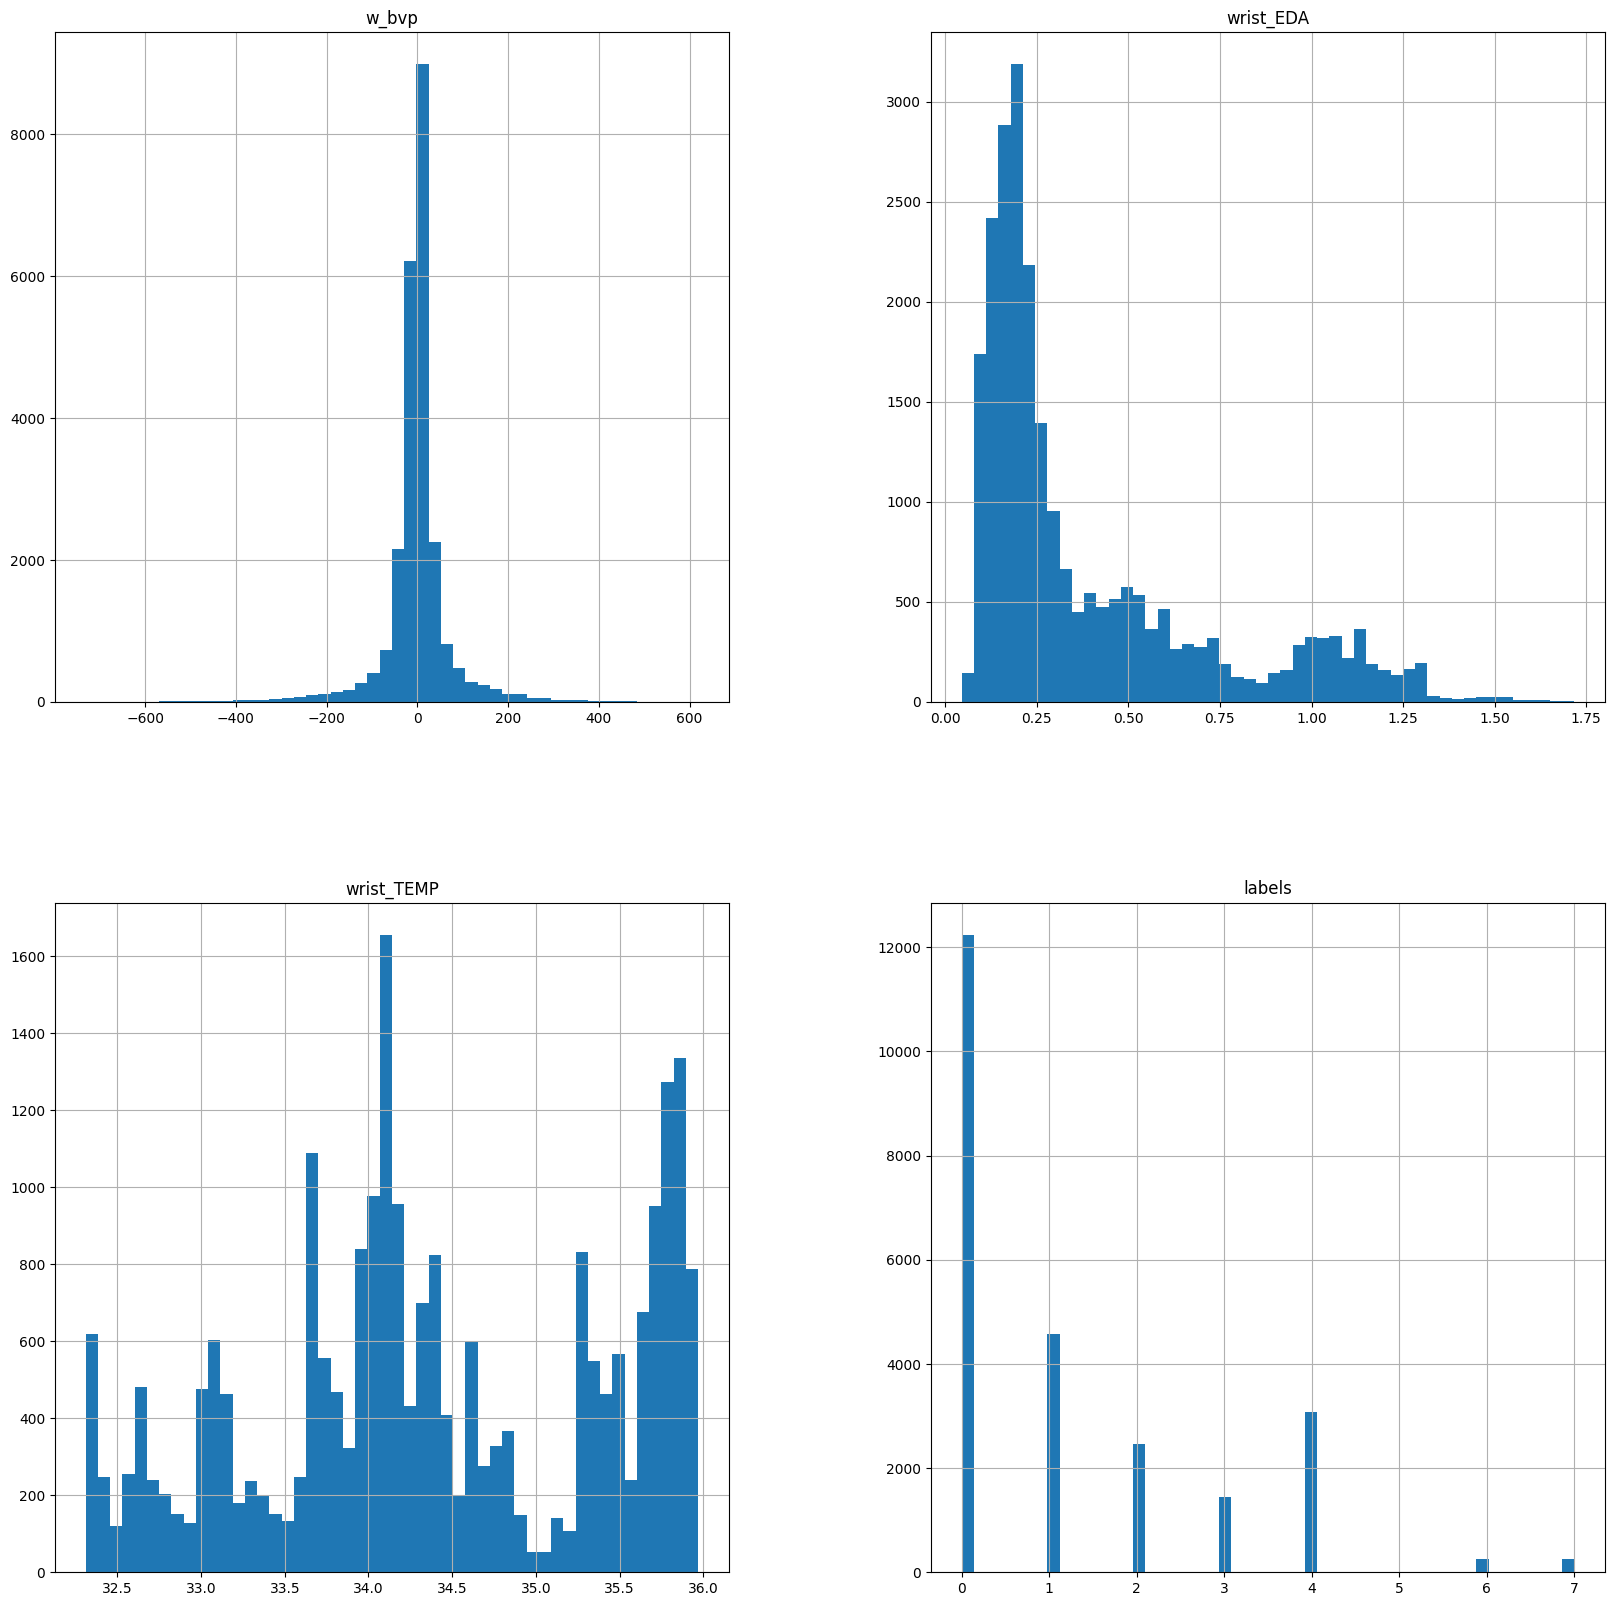

In [22]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,20))
plt.show()

In [23]:
# Applying Interqunatile range
df_25 = df.quantile(0.25)
df_75 = df.quantile(0.75)
IQR = df_75 - df_25

In [24]:
upper = df_75 + 1.5 * IQR 
lower = df_25 - 1.5 * IQR

In [25]:
df_out = df[(df >= lower) & (df <= upper)].dropna()
df_out.shape

(18900, 4)

In [26]:
df_out['labels'].unique()

array([0., 1., 2., 4., 3.])

In [27]:
# removing unwanted lables values from the data
remove = df_out['labels'].isin([0.0, 5.0, 6.0, 7.0])
df_data = df_out[~remove]

In [28]:
df_data['labels'].unique()

array([1., 2., 4., 3.])

In [29]:
df_data.isnull().sum()

w_bvp         0
wrist_EDA     0
wrist_TEMP    0
labels        0
dtype: int64

In [30]:
# Separating, Feature and labels
X = df_data.drop(['labels'], axis=1)
Y = df_data['labels']

In [31]:
from sklearn.model_selection import train_test_split
# Mentionong stratify = Y to make sure target variable is evenly distributed amoung train and test
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.40, stratify=Y)

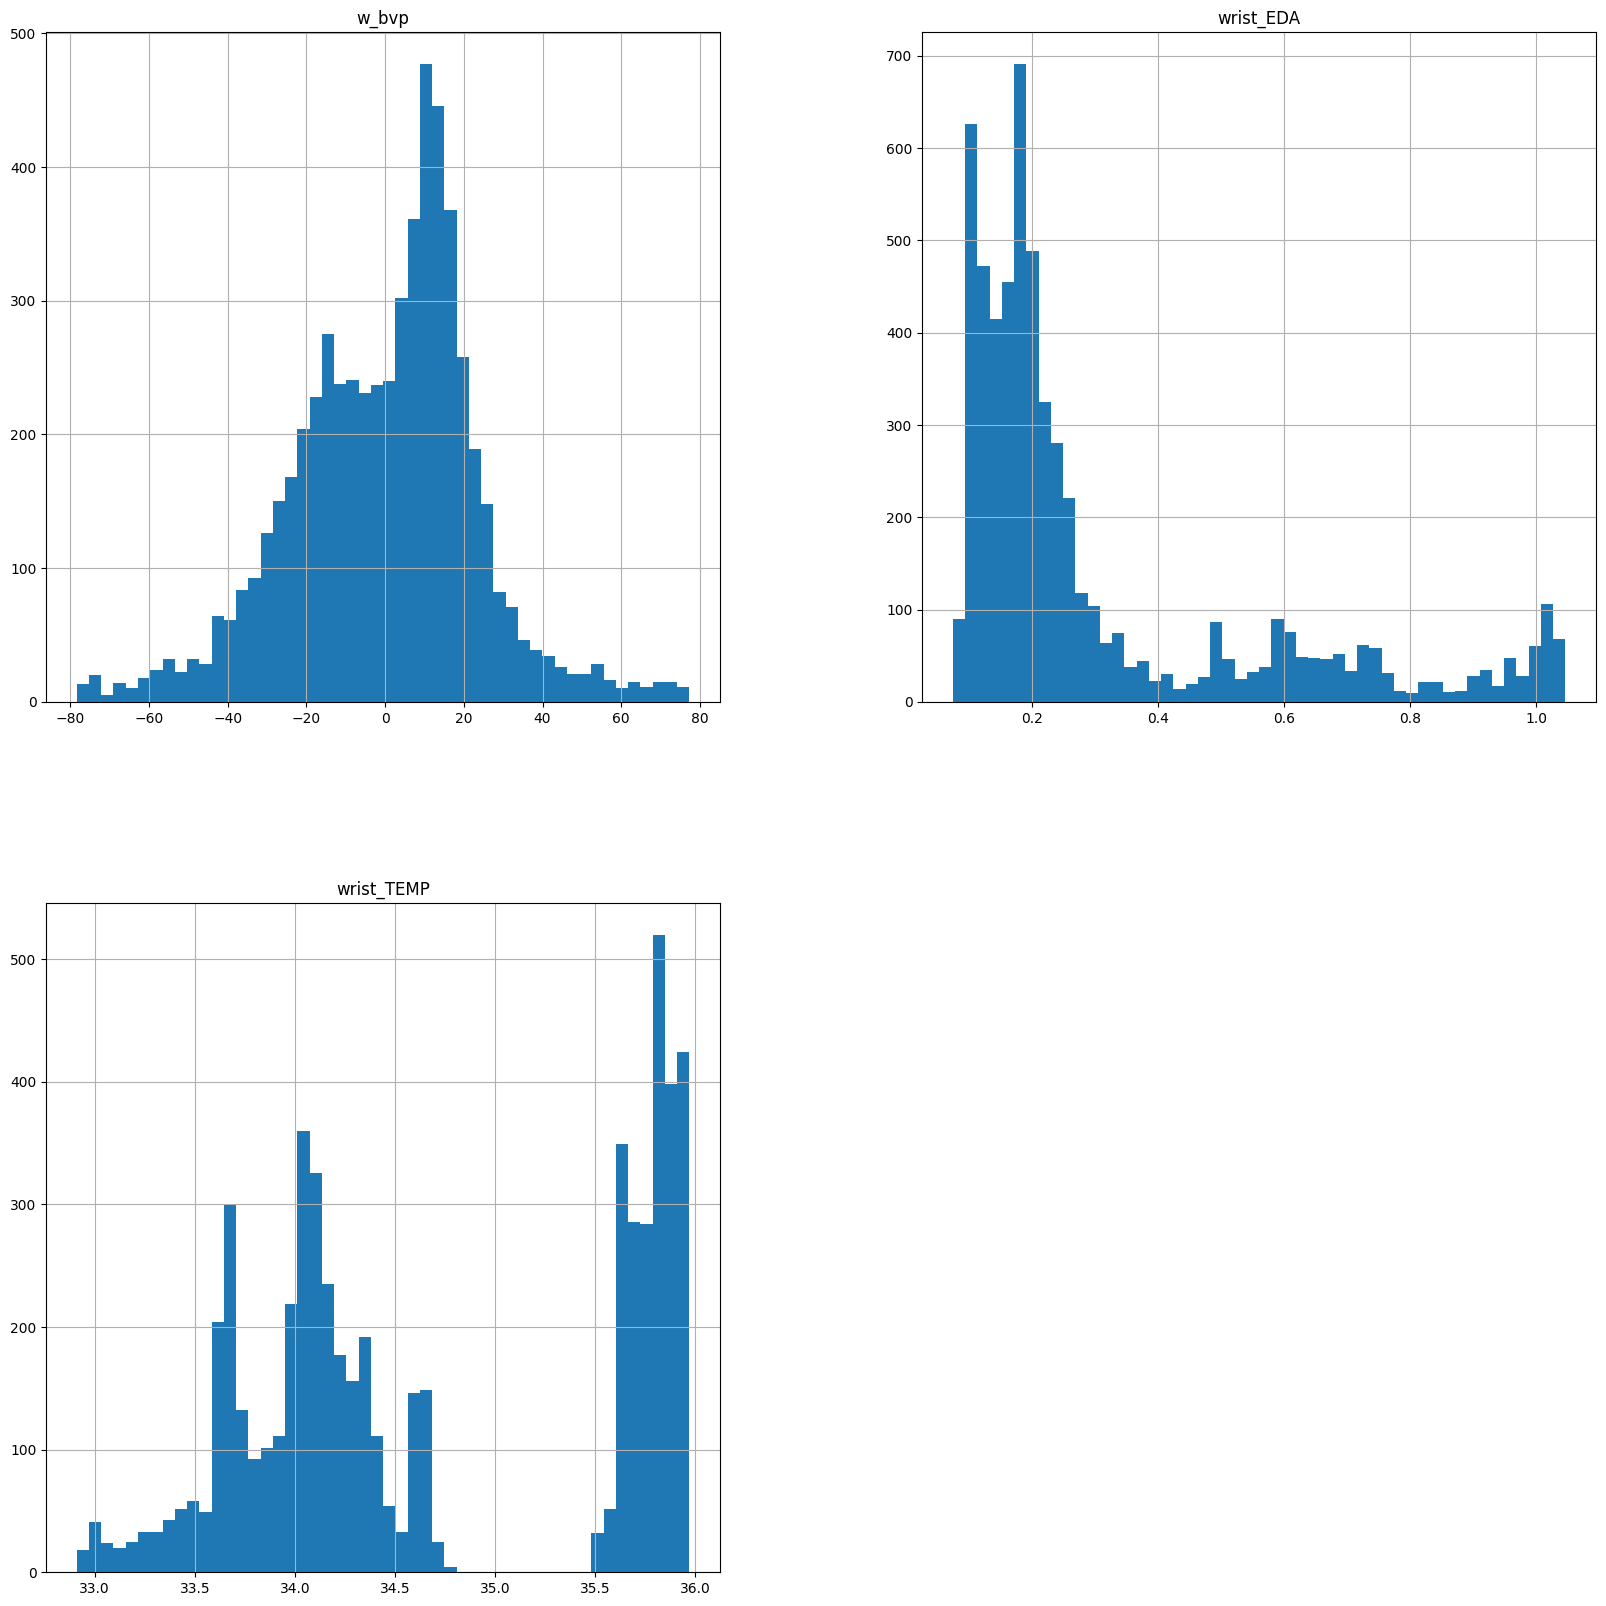

In [32]:
import matplotlib.pyplot as plt

trainX.hist(bins=50, figsize=(20,20))
plt.show()

In [33]:
num_cols = [column for column in trainX.columns if trainX[column].dtypes == np.float64 
                or trainX[column].dtypes == np.int64 ]

num_cols

['w_bvp', 'wrist_EDA', 'wrist_TEMP']

In [34]:
#pipeline for numeric features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Numeric Pipeline
num_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('pca', PCA(0.90))
])

#full pipeline - combine numeric
full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols)
])

trainX_prc = full_pipeline.fit_transform(trainX)
testX_prc = full_pipeline.transform(testX)

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [5, 10, 15],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='accuracy', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [3, 4, 5, 6],
                          'max_features': [5, 10, 15],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40]}],
             return_train_score=True, scoring='accuracy')

In [36]:
print(grid_search.best_params_)
print(grid_search.best_score_) # accuracy

{'max_depth': 6, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9492156566331958


In [37]:
best_dt = grid_search.best_estimator_

In [38]:
# Testing Score
best_dt.score(testX_prc, testY)

0.9419734151329243

In [39]:
# Getting y prediction for testing data
y_pred = best_dt.predict(testX_prc)

In [40]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1563
         2.0       1.00      1.00      1.00       593
         3.0       0.84      0.72      0.78       549
         4.0       0.88      0.94      0.91      1207

    accuracy                           0.94      3912
   macro avg       0.93      0.92      0.92      3912
weighted avg       0.94      0.94      0.94      3912



In [41]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1563
         2.0       1.00      1.00      1.00       593
         3.0       0.84      0.72      0.78       549
         4.0       0.88      0.94      0.91      1207

    accuracy                           0.94      3912
   macro avg       0.93      0.92      0.92      3912
weighted avg       0.94      0.94      0.94      3912



In [42]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(testY, y_pred)
conf_mx

array([[1563,    0,    0,    0],
       [   1,  592,    0,    0],
       [   0,    0,  397,  152],
       [   0,    0,   74, 1133]])

/tmp/ipykernel_2982969/3430290375.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + target)
/tmp/ipykernel_2982969/3430290375.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + target)  # Set labels for y-axis


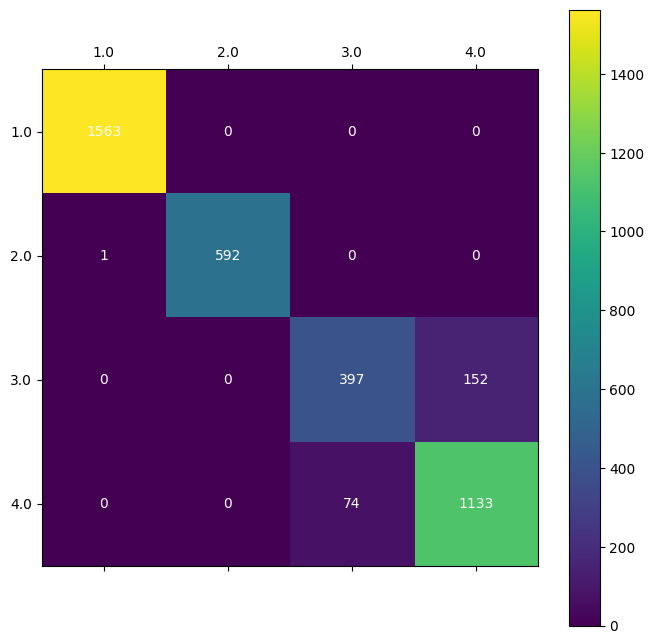

In [43]:
target = [1., 2., 3., 4.]
def plot_confusion_matrix(matrix, target):
    """Displaying with color bar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + target)  
    ax.set_yticklabels([''] + target)  # Set labels for y-axis

    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            ax.text(j, i, str(matrix[i][j]), va='center', ha='center', color='white')

plot_confusion_matrix(conf_mx, target)
plt.show()